In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight

print("Versión de TensorFlow:", tf.__version__)

Versión de TensorFlow: 2.19.0


## Carga y Preparación de los Datos

In [ ]:
# --- Nombre del archivo CSV ---
file_name = 'framingham.csv'
# -----------------------------

try:
    data = pd.read_csv('./sample_data/framingham.csv')
    print("¡CSV 'framingham.csv' cargado exitosamente!")

    # --- INICIO DE LIMPIEZA DE DATOS (ETL) ---

    # 1. Eliminar columnas que no usaremos
    # 'education' no es un dato clínico relevante para el formulario
    data = data.drop(columns=['education'])

    # 2. Manejar valores nulos (NaN)
    # Llenaremos los valores faltantes con el promedio (media) de su columna.
    # Esto soluciona los datos faltantes en 'glucose', 'totChol', 'BMI', etc.
    print(f"Valores nulos ANTES de la limpieza:\n{data.isnull().sum()}")

    data.fillna(data.mean(), inplace=True)

    print(f"\nValores nulos DESPUÉS de la limpieza:\n{data.isnull().sum()}")
    print("--- Limpieza de datos completada ---")

    # --- FIN DE LIMPIEZA DE DATOS ---

    # 3. Definir columnas (FEATURES)
    # ¡IMPORTANTE! Estas columnas deben coincidir con tu formulario.
    # He seleccionado las columnas de 'framingham.csv' que SÍ existen en tu formulario.
    FEATURES = [
        'age',              # Coincide con 'edad'
        'male',             # Coincide con 'sexo'
        'sysBP',            # Coincide con 'presion_sistolica'
        'diaBP',            # Coincide con 'presion_diastolica'
        'totChol',          # Coincide con 'colesterol_total'
        'glucose',          # Coincide con 'glucosa'
        'BMI',              # Se calculará en tu app desde 'peso' y 'altura'
        'currentSmoker'     # Coincide con 'fumador'
    ]

    # Esta es la "respuesta" (Target)
    TARGET = 'TenYearCHD' # (Riesgo de enfermedad a 10 años)

    # 4. Separar datos en X (features) e y (target)
    X = data[FEATURES]
    y = data[TARGET]

    # 5. Dividir en conjuntos de entrenamiento y prueba (80% / 20%)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # 6. Escalar los datos (¡CRÍTICO!)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    print(f"\nDatos listos: {len(X_train)} muestras de entrenamiento, {len(X_test)} muestras de prueba.")

    # 7. Guardar el escalador
    # Tu agente de Python necesitará este archivo.
    joblib.dump(scaler, 'scaler.joblib')
    print("✅ Escalador guardado como 'scaler.joblib'")

    # Calcular los pesos para balancear las clases 0 y 1
    weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train), # Clases son 0 y 1
        y=y_train # Calcular pesos basados en los datos de entrenamiento
    )
    # Crear un diccionario que Keras pueda entender (ej. {0: 0.5, 1: 3.5})
    class_weights_dict = dict(zip(np.unique(y_train), weights))
    print(f"✅ Pesos de clase calculados para balancear: {class_weights_dict}")
    # -----------------------

except FileNotFoundError:
    print(f"Error: No se encontró el archivo '{file_name}'.")
    print("Por favor, súbelo al panel izquierdo de Colab y vuelve a intentarlo.")

¡CSV 'framingham.csv' cargado exitosamente!
Valores nulos ANTES de la limpieza:
male                 0
age                  0
currentSmoker        0
cigsPerDay          29
BPMeds              53
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             50
sysBP                0
diaBP                0
BMI                 19
heartRate            1
glucose            388
TenYearCHD           0
dtype: int64

Valores nulos DESPUÉS de la limpieza:
male               0
age                0
currentSmoker      0
cigsPerDay         0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
sysBP              0
diaBP              0
BMI                0
heartRate          0
glucose            0
TenYearCHD         0
dtype: int64
--- Limpieza de datos completada ---

Datos listos: 3392 muestras de entrenamiento, 848 muestras de prueba.
✅ Escalador guardado como 'scaler.joblib'
✅ Pesos de clase calculados para balancear: {

## Construcción del Modelo de IA (Keras)

In [ ]:
if 'data' in locals():
    # Definir el modelo Keras Sequential
    model = keras.Sequential([
        # Capa de entrada. 'shape' debe coincidir con el número de features (14)
        layers.Input(shape=(len(FEATURES),)),

        # Primera capa oculta [cite: 419]
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3), # Dropout para prevenir sobreajuste

        # Segunda capa oculta [cite: 420]
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.3),

        # Capa de salida [cite: 421]
        # 'sigmoid' es para clasificación binaria (0 o 1)
        layers.Dense(1, activation='sigmoid')
    ])

    # Compilar el modelo [cite: 427]
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy', # Pérdida para clasificación binaria [cite: 429]
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')
        ] # Métricas de tu documento [cite: 431, 443-445]
    )

    # Mostrar un resumen del modelo
    model.summary()
else:
    print("Error: Los datos no fueron cargados. Ejecuta la celda anterior primero.")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,689 (10.50 KB)

 Trainable params: 2,689 (10.50 KB)

 Non-trainable params: 0 (0.00 B)

## Entrenamiento del Modelo

Iniciando entrenamiento (¡AHORA BALANCEADO!)...
Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5638 - loss: 0.6825 - precision: 0.1809 - recall: 0.5605 - val_accuracy: 0.6686 - val_loss: 0.5985 - val_precision: 0.3034 - val_recall: 0.6750
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6217 - loss: 0.6101 - precision: 0.2194 - recall: 0.6499 - val_accuracy: 0.6230 - val_loss: 0.6132 - val_precision: 0.2848 - val_recall: 0.7500
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6212 - loss: 0.6115 - precision: 0.2377 - recall: 0.7230 - val_accuracy: 0.6436 - val_loss: 0.5943 - val_precision: 0.2897 - val_recall: 0.7000
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6494 - loss: 0.6134 - precision: 0.2635 - recall: 0.7170 - val_accuracy: 0.6598 - val_loss: 0.5845 - val_precision: 0.3025 - val_recall: 0.7083
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6626 - loss: 0.6027 - precision: 0.2522 - recall: 0.6640

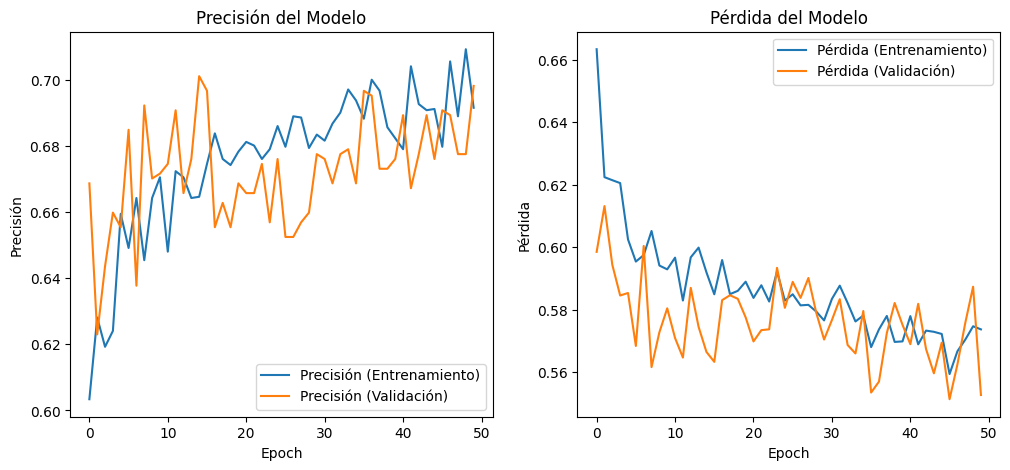

In [ ]:
if 'model' in locals():
    print("Iniciando entrenamiento (¡AHORA BALANCEADO!)...")

    # Entrenar el modelo
    history = model.fit(
        X_train_scaled,
        y_train,
        epochs=50,
        batch_size=32,
        validation_split=0.2,

        # --- ¡LÍNEA NUEVA! ---
        # Aquí le decimos a Keras que penalice más
        # los errores en la clase minoritaria (1).
        class_weight=class_weights_dict,
        # ---------------------

        verbose=1
    )

    print("\n¡Entrenamiento completado!")

    # (El resto del código de la celda para graficar es igual)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.plot(history.history['accuracy'], label='Precisión (Entrenamiento)')
    ax1.plot(history.history['val_accuracy'], label='Precisión (Validación)')
    ax1.set_title('Precisión del Modelo')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Precisión')
    ax1.legend()

    ax2.plot(history.history['loss'], label='Pérdida (Entrenamiento)')
    ax2.plot(history.history['val_loss'], label='Pérdida (Validación)')
    ax2.set_title('Pérdida del Modelo')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Pérdida')
    ax2.legend()

    plt.show()

else:
    print("Error: El modelo no fue construido. Ejecuta la celda anterior primero.")

## Evaluación del Modelo


--- 1. Evaluación en el conjunto de prueba ---
Pérdida (Loss): 0.5706
Precisión (Accuracy): 0.7052
Precisión (Precision): 0.2646
Exhaustividad (Recall): 0.5271

--- 2. Reporte de Clasificación ---
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
                precision    recall  f1-score   support

Sin Riesgo (0)       0.90      0.74      0.81       719
Con Riesgo (1)       0.26      0.53      0.35       129

      accuracy                           0.71       848
     macro avg       0.58      0.63      0.58       848
  weighted avg       0.80      0.71      0.74       848


--- 3. Matriz de Confusión ---


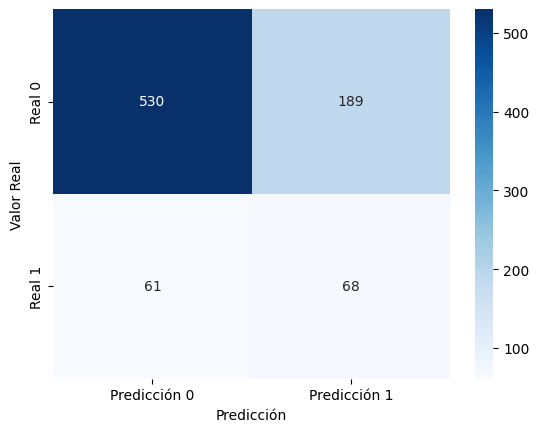

In [ ]:
if 'history' in locals():
    print("\n--- 1. Evaluación en el conjunto de prueba ---")

    # Evaluar el modelo en el conjunto de prueba
    results = model.evaluate(X_test_scaled, y_test, verbose=0)

    print(f"Pérdida (Loss): {results[0]:.4f}")
    print(f"Precisión (Accuracy): {results[1]:.4f}")
    print(f"Precisión (Precision): {results[2]:.4f}")
    print(f"Exhaustividad (Recall): {results[3]:.4f}")

    print("\n--- 2. Reporte de Clasificación ---")
    # Generar predicciones
    y_pred_probs = model.predict(X_test_scaled)
    y_pred_classes = (y_pred_probs > 0.5).astype(int) # Convertir probabilidades (ej 0.8) a clases (1)

    # Imprimir reporte
    print(classification_report(y_test, y_pred_classes, target_names=['Sin Riesgo (0)', 'Con Riesgo (1)']))

    print("\n--- 3. Matriz de Confusión ---")
    # Mostrar la Matriz de Confusión
    cm = confusion_matrix(y_test, y_pred_classes)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicción 0', 'Predicción 1'],
                yticklabels=['Real 0', 'Real 1'])
    plt.xlabel('Predicción')
    plt.ylabel('Valor Real')
    plt.show()

else:
    print("Error: El modelo no ha sido entrenado. Ejecuta la celda anterior primero.")

## Guardado de los Archivos Finales

In [ ]:
if 'model' in locals():
    # Guardar el modelo entrenado en formato H5 [cite: 439]
    model_filename = 'modelo_cardiovascular.h5'
    model.save(model_filename)

    print(f"\n¡LISTO! Se han guardado los dos archivos que necesitas:")
    print(f"✅ 1. {model_filename} (Tu modelo de IA)")
    print(f"✅ 2. scaler.joblib (Tu escalador de datos)")
    print("\nDescarga ambos archivos desde el panel izquierdo de Colab.")

else:
    print("Error: El modelo no existe.")


¡LISTO! Se han guardado los dos archivos que necesitas:
✅ 1. modelo_cardiovascular.h5 (Tu modelo de IA)
✅ 2. scaler.joblib (Tu escalador de datos)

Descarga ambos archivos desde el panel izquierdo de Colab.
